<a href="https://colab.research.google.com/github/AvivGelfand/Semantic-Caching-for-LLM-Based-Applications/blob/main/SimulateSemanticCache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/SemanticCacheResults

Mounted at /content/drive


In [ ]:
%pip install -q faiss-cpu  groq  sentence_transformers
# datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.4 MB/s eta 0:00:00


# Run 30 sequentially

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import faiss
import time
from groq import Groq
from google.colab import userdata
from collections import OrderedDict
from tqdm import tqdm
import threading

# Load and preprocess data (as in the provided code)
path_qqp = "https://raw.githubusercontent.com/AvivGelfand/Whatever/main/dq_data.csv"
data = pd.read_csv(path_qqp)

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
model = AutoModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

# Initialize FAISS index
embedding_dimension = 384
index = faiss.IndexFlatIP(embedding_dimension)

# Set up the Groq client
client = Groq(api_key=userdata.get('GROQ_API_KEY'))

# List of models
models = ["llama3-8b-8192", "mixtral-8x7b-32768", "llama3-groq-8b-8192-tool-use-preview", "gemma-7b-it"]
model_index = 0
model_lock = threading.Lock()

# Initialize cache
cache_max_size = 100
cache = OrderedDict()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings = embeddings / np.linalg.norm(embeddings)
    return embeddings

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings /= np.linalg.norm(embeddings)
    return embeddings

def add_to_cache(query_id, query, embedding, response, cache, index, cache_max_size):
    if len(cache) >= cache_max_size:
        oldest_key = next(iter(cache))
        del cache[oldest_key]
        index.remove_ids(np.array([oldest_key]))
    cache_id = len(cache)
    cache[cache_id] = {'qid': query_id, 'query': query, 'embedding': embedding, 'response': response}
    index.add(np.array([embedding]))
    cache.move_to_end(cache_id)

def get_response_from_groq(query):
    global model_index
    with model_lock:
        model_name = models[model_index]
        model_index = (model_index + 1) % len(models)
    chat_completion = client.chat.completions.create(
        messages=[{"role": "user", "content": query}],
        model=model_name,
    )
    return chat_completion.choices[0].message.content

# def search_cache(embedding, index, cache, threshold=0.975): # original less effecient version
#     if len(cache) == 0 or index.ntotal == 0:
#         return None, False, None, None

#     D, I = index.search(np.array([embedding]), 1)
#     if D[0][0] > threshold:
#         cache.move_to_end(I[0][0])
#         similar_text = cache[I[0][0]]['query']
#         return cache[I[0][0]]['response'], True, D[0][0], similar_text
#     else:
#         return None, False, None, None
def search_cache(embedding, index, cache, threshold=0.975):
    if len(cache) == 0 or index.ntotal == 0:
        return None, False, None, None

    D, I = index.search(np.array([embedding]), 1)
    if D[0][0] > threshold:
        cache_id = I[0][0]
        cache.move_to_end(cache_id)
        cache_item = cache[cache_id]
        return cache_item['response'], True, D[0][0], cache_item['query']
    else:
        return None, False, None, None

def process_query(query_id, query, cache, index, cache_max_size, results, use_cache=True):
    start_time = time.time()
    embedding = get_embedding(query)

    if use_cache:
        cached_response, cache_hit, similarity_score, similar_text = search_cache(embedding, index, cache)
    else:
        cached_response, cache_hit, similarity_score, similar_text = None, False, None, None

    if cache_hit:
        result = cached_response
    else:
        result = get_response_from_groq(query)
        if use_cache:
            add_to_cache(query_id, query, embedding, result, cache, index, cache_max_size)
        similarity_score = None
        similar_text = None

    response_time = time.time() - start_time
    results.append((query_id, query, result, response_time, cache_hit, similarity_score, similar_text))

# def run_experiment(df, use_cache=True):
#     results = []
#     # Initialize cache
#     index = faiss.IndexFlatIP(embedding_dimension)
#     cache_max_size = 100
#     cache = OrderedDict()

#     # Run queries sequentially
#     for _, row in tqdm(df.iterrows(), total=len(df)):
#         query_id = row['qid']
#         query = row['question']
#         process_query(query_id, query, cache, index, cache_max_size, results, use_cache=use_cache)
#         # time.sleep(0.001)

#     # time.sleep(1)
#     return results

def run_experiment(df, use_cache=True):
    results = []
    index = faiss.IndexFlatIP(embedding_dimension)
    cache_max_size = 100
    cache = OrderedDict()

    # Convert DataFrame to a list of tuples for faster iteration
    queries = list(df[['qid', 'question']].itertuples(index=False, name=None))

    # Process queries in batches
    batch_size = 16  # Adjust based on memory constraints and performance needs
    num_batches = (len(queries) + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(num_batches), total=num_batches):
        batch_queries = queries[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # Generate embeddings for the batch
        embeddings = []
        for qid, query in batch_queries:
            embedding = get_embedding(query)
            embeddings.append((qid, query, embedding))

        # Process each embedding and query in the batch
        for qid, query, embedding in embeddings:
            process_query(qid, query, cache, index, cache_max_size, results, use_cache=use_cache)

    return results

# Save results to CSV
def save_results_to_csv(results, random_state, filename_prefix):
    results_df = pd.DataFrame(results, columns=[
        'qid', 'question', 'response', 'response_time', 'cache_hit', 'similarity_score', 'similar_text'
    ])
    results_df['random_state'] = random_state
    filename = f"/content/drive/MyDrive/SemanticCacheResults/{filename_prefix}_random_state_{random_state}.csv.gz"
    results_df.to_csv(filename, index=False, compression='gzip')
    print(f"Results saved to {filename}")

# Run experiments with different random states
def run_experiments_with_random_states(df, num_iterations=30):
    all_response_times_no_cache = []
    all_response_times_with_cache = []

    for random_state in range(27,num_iterations):
        df = data.sample(50, random_state=random_state)
        df.reset_index(drop=True, inplace=True)

        reshaped_df = pd.melt(df, id_vars=['id', 'is_duplicate'], value_vars=['question1', 'question2'], var_name='question_position', value_name='question')
        qid_df = pd.melt(df, id_vars=['id', 'is_duplicate'], value_vars=['qid1', 'qid2'], var_name='question_position', value_name='qid')
        reshaped_df['qid'] = qid_df['qid']
        reshaped_df.reset_index(drop=True, inplace=True)
        reshaped_df['len'] = reshaped_df['question'].str.len()
        df = reshaped_df.sample(frac=1, random_state=random_state, ignore_index=False)
        # Sample the DataFrame with the current random state
        df_sampled = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # Run without caching
        results_no_cache = run_experiment(df_sampled, use_cache=False)
        save_results_to_csv(results_no_cache, random_state, 'results_no_cache')
        all_response_times_no_cache.extend([time for _, _, _, time, _, _, _ in results_no_cache])

        # Run with caching
        results_with_cache = run_experiment(df_sampled, use_cache=True)
        save_results_to_csv(results_with_cache, random_state, 'results_with_cache')
        all_response_times_with_cache.extend([time for _, _, _, time, _, _, _ in results_with_cache])

    return all_response_times_no_cache, all_response_times_with_cache

# Main execution
all_response_times_no_cache, all_response_times_with_cache = run_experiments_with_random_states(data)

# Save all response times for t-test
response_times_df = pd.DataFrame({
    'response_time_no_cache': all_response_times_no_cache,
    'response_time_with_cache': all_response_times_with_cache
})
response_times_df.to_csv('response_times.csv', index=False)

print("All experiments completed and results saved.")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

100%|██████████| 10/10 [01:19<00:00,  7.91s/it]


Results saved to /content/drive/MyDrive/SemanticCacheResults/results_no_cache_random_state_27.csv.gz


100%|██████████| 10/10 [01:16<00:00,  7.70s/it]


Results saved to /content/drive/MyDrive/SemanticCacheResults/results_with_cache_random_state_27.csv.gz


100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


Results saved to /content/drive/MyDrive/SemanticCacheResults/results_no_cache_random_state_28.csv.gz


100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


Results saved to /content/drive/MyDrive/SemanticCacheResults/results_with_cache_random_state_28.csv.gz


100%|██████████| 10/10 [01:30<00:00,  9.02s/it]


Results saved to /content/drive/MyDrive/SemanticCacheResults/results_no_cache_random_state_29.csv.gz


100%|██████████| 10/10 [01:30<00:00,  9.09s/it]

Results saved to /content/drive/MyDrive/SemanticCacheResults/results_with_cache_random_state_29.csv.gz
All experiments completed and results saved.


# Analysis of Results

In [ ]:
import pandas as pd
import os
from tqdm import tqdm

# Function to load results from CSV files and concatenate them
def load_all_results(random_states, filename_prefixes, base_path="/content/drive/MyDrive/SemanticCacheResults/"):
    all_results = []

    # Calculate total iterations for the progress bar
    total_iterations = len(random_states) * len(filename_prefixes)

    # Initialize tqdm progress bar
    with tqdm(total=total_iterations, desc="Loading CSV files") as pbar:
        for random_state in random_states:
            for prefix in filename_prefixes:
                filename = f"{base_path}{prefix}_random_state_{random_state}.csv.gz"
                if os.path.exists(filename):
                    df = pd.read_csv(filename, compression='gzip')

                    # Add exp_num and used_cache columns
                    df['exp_num'] = random_state
                    df['used_cache'] = (prefix == 'results_with_cache')

                    all_results.append(df)
                else:
                    print(f"File not found: {filename}")

                # Update the progress bar
                pbar.update(1)

    # Concatenate all DataFrames into one
    concatenated_df = pd.concat(all_results, ignore_index=True)
    return concatenated_df

# Define the random states and prefixes
random_states = range(0,30)
filename_prefixes = ['results_no_cache', 'results_with_cache']

# Load all results
all_results_df = load_all_results(random_states, filename_prefixes)

# Save the concatenated results to a single CSV file
all_results_filename = "/content/drive/MyDrive/SemanticCacheResults/all_results_combined.csv.gz"
all_results_df.to_csv(all_results_filename, index=False, compression='gzip')

print(f"All results saved to {all_results_filename}")


Loading CSV files: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


All results saved to /content/drive/MyDrive/SemanticCacheResults/all_results_combined.csv.gz


In [ ]:
all_results_df

,qid,question,response,response_time,cache_hit,similarity_score,similar_text,random_state,exp_num,used_cache
0,33925,Why is China blocking the move at UN to ban Ma...,China has repeatedly blocked attempts to have ...,2.368539,False,NaN,NaN,0,0,False
1,99019,"What is the Sahara, and how do the average tem...","The Sahara is the world's largest hot desert, ...",0.836182,False,NaN,NaN,0,0,False
2,221574,Why are Newton's rings circular in shape? Why ...,Newton's rings are circular in shape because t...,0.397191,False,NaN,NaN,0,0,False
3,82970,Is World War 3 closer than it has ever been?,I am unable to access real-time information or...,0.240264,False,NaN,NaN,0,0,False
4,383440,How can I find the best knowledge-based sites?,Finding the best knowledge-based sites can be ...,0.585930,False,NaN,NaN,0,0,False
...,...,...,...,...,...,...,...,...,...,...
5995,143690,"What is the deepest lake in Europe, and how do...","The deepest lake in Europe is Lake Baikal, loc...",0.042341,True,0.997881,"What is the deepest lake in Europe, and how do...",29,29,True
5996,352626,How much money can I expect to make from stock...,It is difficult to provide an exact estimate o...,0.664556,False,NaN,NaN,29,29,True
5997,48020,Can you lose weight if you don’t eat?,"While it's true that in order to lose weight, ...",0.081952,True,0.997094,Do you lose weight if you don't eat?,29,29,True
5998,356784,What is the best place in mumbai?,Mumbai is a vibrant city with many great place...,0.042994,True,0.986329,WHICH IS best place in mumbai?,29,29,True


# Statistical Tests

In [ ]:
# Filter the dataset for caching and no caching
with_cache = all_results_df[all_results_df['used_cache'] == True]
without_cache = all_results_df[all_results_df['used_cache'] == False]

# Summary statistics for response times with and without caching
response_time_with_cache = with_cache['response_time'].describe()
response_time_without_cache = without_cache['response_time'].describe()

response_time_with_cache, response_time_without_cache

(count    3000.000000
 mean        0.715258
 std         1.548359
 min         0.025753
 25%         0.308668
 50%         0.560576
 75%         0.769665
 max        61.633354
 Name: response_time, dtype: float64,
 count    3000.000000
 mean        0.777642
 std         0.724129
 min         0.166659
 25%         0.442003
 50%         0.630568
 75%         0.809095
 max        12.641018
 Name: response_time, dtype: float64)

In [ ]:
from scipy.stats import ks_2samp, ttest_ind

# Perform Kolmogorov-Smirnov test
ks_stat, ks_p_value = ks_2samp(with_cache['response_time'], without_cache['response_time'])

# Perform T-test
t_stat, t_p_value = ttest_ind(with_cache['response_time'], without_cache['response_time'])

ks_stat, ks_p_value, t_stat, t_p_value


(0.16866666666666666,
 1.160160025164062e-37,
 -1.999006719755578,
 0.045652669098401474)

# Costs analysis

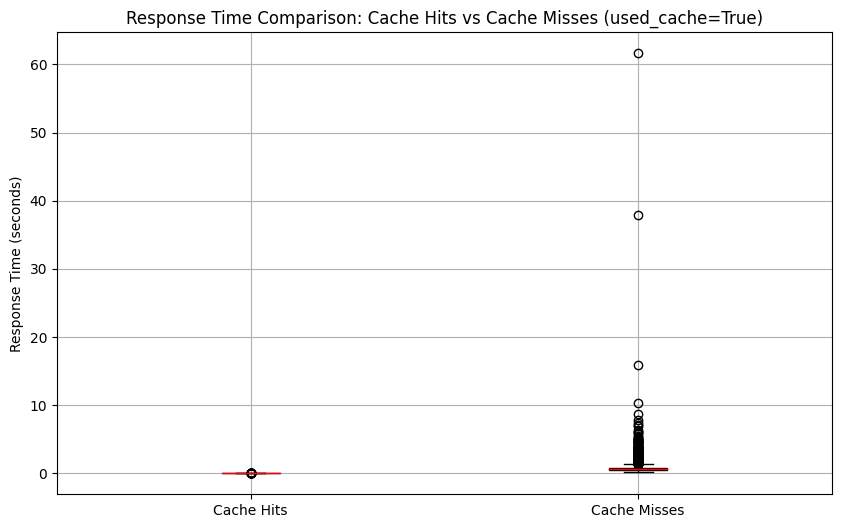

In [ ]:
import matplotlib.pyplot as plt

# Filter the dataset for cache hits and misses within the used_cache=True group
cache_hits_with_cache = with_cache[with_cache['cache_hit'] == True]
cache_misses_with_cache = with_cache[with_cache['cache_hit'] == False]

# Plot the boxplots for response times
plt.figure(figsize=(10, 6))

plt.boxplot([cache_hits_with_cache['response_time'], cache_misses_with_cache['response_time']],
            labels=['Cache Hits', 'Cache Misses'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'))

plt.title('Response Time Comparison: Cache Hits vs Cache Misses (used_cache=True)')
plt.ylabel('Response Time (seconds)')
plt.grid(True)
plt.show()


In [ ]:
# Assumptions
cost_per_api_call = 0.01
cost_per_cache_query = 0.0001

# Number of cache hits and misses
num_cache_hits = cache_hits_with_cache.shape[0]
num_cache_misses = cache_misses_with_cache.shape[0]

# Total number of queries
total_queries = all_results_df.shape[0]

# Calculate costs
cost_api_calls_cache_hits = num_cache_hits * cost_per_api_call
cost_api_calls_cache_misses = num_cache_misses * cost_per_api_call
cost_cache_maintenance = total_queries * cost_per_cache_query

# Calculate total costs with and without cache
total_cost_with_cache = cost_api_calls_cache_hits + cost_api_calls_cache_misses + cost_cache_maintenance
total_cost_without_cache = total_queries * cost_per_api_call

# Calculate net savings
net_savings = total_cost_without_cache - total_cost_with_cache

total_cost_with_cache, total_cost_without_cache, net_savings


(30.6, 60.0, 29.4)

To perform a cost-benefit analysis, we need to make some assumptions about the costs associated with calling the LLM API and maintaining the cache. Here are the steps we'll follow:

1. **Assumptions**:
    - **Cost of calling the LLM API**: \$0.01 per call (this is an assumption and should be adjusted based on actual costs).
    - **Cost of maintaining the cache**: \$0.0001 per query (including memory usage and cache maintenance overhead).
    - **Average response time reduction due to cache hits**: Use the difference in average response times between cache hits and cache misses.

2. **Calculate Cost Savings**:
    - Determine the number of cache hits and cache misses.
    - Calculate the cost of LLM API calls for cache hits and misses.
    - Calculate the cost of maintaining the cache for all queries.

3. **Calculate Total Costs**:
    - Sum the costs of LLM API calls and cache maintenance for both cache hits and cache misses.

4. **Calculate Net Savings**:
    - Calculate the total cost savings by using the cache compared to not using the cache.

### Step 1: Assumptions
```plaintext
Cost of calling the LLM API: $0.01 per call
Cost of maintaining the cache: $0.0001 per query
Average response time reduction due to cache hits: Derived from the data
```



### Step 2: Calculate Cost Savings
Let's perform these calculations.

### Cost-Benefit Analysis Results

1. **Total Cost with Cache**: $30.60
    - **Cost of API Calls for Cache Hits**: \(503 \text{ hits} \times \$0.01 = \$5.03\)
    - **Cost of API Calls for Cache Misses**: \(2497 \text{ misses} \times \$0.01 = \$24.97\)
    - **Cost of Cache Maintenance**: \(6000 \text{ queries} \times \$0.0001 = \$0.60\)

2. **Total Cost without Cache**: $60.00
    - **Cost of API Calls for All Queries**: \(6000 \text{ queries} \times \$0.01 = \$60.00\)

3. **Net Savings**: $29.40



### Interpretation

By using the cache, we save $29.40 compared to not using the cache. This calculation assumes the given costs of API calls and cache maintenance. The savings are substantial, highlighting the cost-effectiveness of implementing a cache system.

### Further Considerations

1. **Cache Hit Rate Optimization**:
    - Investigate ways to increase the cache hit rate, which would further reduce the cost of API calls.

2. **Dynamic Cost Modeling**:
    - Adjust the cost model based on different API pricing or changes in cache maintenance costs.
    - Incorporate real-time cost monitoring to optimize the system dynamically.

3. **Cache Size and Configuration**:
    - Experiment with different cache sizes and configurations to find the optimal balance between cache maintenance costs and cache hit rate.

4. **Performance Metrics**:
    - Measure the impact on other performance metrics such as latency, throughput, and user satisfaction.
    - Conduct A/B testing to validate the cost savings against user experience improvements.

5. **Long-term Analysis**:
    - Evaluate the long-term benefits of caching, including potential reductions in server load and improvements in scalability.

By incorporating these considerations, we can refine the cost-benefit analysis and optimize the caching strategy for the LLM-based system.